This script test the impact of using different types of spectral constraints to estimate the desired graph. Graphs are generated as grid graphs where each node has 4 neighbors except those nodes on the borders. The error of the recovered graph is computed as the number of samples increases.

In [2]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

import utils
import spectral_nti as snti

# %matplotlib qt

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)
DATASET_PATH = 'data/senate_data/'

## Considered constraints

In [3]:
GS = [
    lambda a, b : cp.sum(a)/b,
    lambda a, b : cp.sum(a**2)/b,
    lambda a, b : cp.sum(cp.exp(-a))/b,
    lambda a, b : cp.sum(.25*a**2-.75*a)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b: 1/b*(0.75-2*0.25*lamd_t).T@lamd,
]

## Auxiliary functions

In [4]:
def get_colors(labels):
    colors = []
    for i in range(labels.size):
        if labels[i] == 'R':
            colors.append('blue')
        elif labels[i] == 'D':
            colors.append('red')
        elif labels[i] == 'M':
            colors.append('yellow')
        else:
            raise Exception('Unknown node label')
    return colors

def est_graph(id, models, MM, L, iters):
    X = utils.create_signals(L, MM[-1])

    N = X.shape[0]
    L_hat = np.zeros((N, N, len(models), len(MM)))
    lamd_hat = np.zeros((N, len(models), len(MM)))
    for i,M in enumerate(MM):
        C_hat = X[:,:M]@X[:,:M].T/M

        # Individual standard constraints
        for j, model in enumerate(models):
            t = time.time()
            L_hat[:,:,j,i], lamd_hat[:,j,i] = utils.est_graph(C_hat, model, iters) 
            t = time.time() - t
            print('Cov-{}, M-{}: Model: {} - Time(sec): {:.3}'.format(id, M, model['name'], t))
    return L_hat, lamd_hat


def est_errs1(L, lamd, L_hat, lams_hat, sq_err=True):
    norm_L = np.linalg.norm(L, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)
    
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        for i in range(L_hat.shape[-2]):
            for j in range(L_hat.shape[-3]):
                err_L[j,i,k] = np.linalg.norm(L-L_hat[:,:,j,i,k], 'fro')/norm_L
                err_lamb[j,i,k] = np.linalg.norm(lamd-lams_hat[:,j,i,k], 2)/norm_lam

                if sq_err:
                    err_L[j,i,k] = err_L[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_L, err_lamb


def est_errs2(L, lamd, L_hat, lams_hat, sq_err=True):
    norm_L = np.linalg.norm(L, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)
    
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        for i in range(L_hat.shape[-2]):
            for j in range(L_hat.shape[-3]):
                if np.all((L_hat[:,:,j,i,k] == 0)):
                    norm_L_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_L_hat = np.linalg.norm(L_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                L_hat_norm = L_hat[:,:,j,i,k]/norm_L_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_L[j,i,k] = np.linalg.norm(L/norm_L-L_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_L[j,i,k] = err_L[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_L, err_lamb


def plot_err(MM, models, err, ylab, logy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if logy:
            plt.semilogy(MM, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(MM, err[i,:], model['fmt'], label=model['name'],
                         linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('M')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([MM[0], MM[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


## Read data and estimate true graph

In [5]:
X113 = np.load(DATASET_PATH + 'X113.npy')
X114 = np.load(DATASET_PATH + 'X114.npy')
X115 = np.load(DATASET_PATH + 'X115.npy')
labels113 = np.load(DATASET_PATH + 'labels113.npy')
labels114 = np.load(DATASET_PATH + 'labels114.npy')
labels115 = np.load(DATASET_PATH + 'labels115.npy')

C113 = np.cov(X113)
C114 = np.cov(X114)
C115 = np.cov(X115)

colors113 = get_colors(labels113)
colors114 = get_colors(labels114)
colors115 = get_colors(labels115)



In [127]:
# np.save(DATASET_PATH + 'L113', L113)
# np.save(DATASET_PATH + 'L114_v2', L114)
# np.save(DATASET_PATH + 'L115_v2', L115)

## Read graphs

In [137]:
regs114 = {'alpha': .01, 'beta': 7.5}
L0, _ = snti.MGL(C114, [], [], [], regs114, max_iters=200, verbose=False)
A0 = np.diag(np.diag(L0)) - L0
lambdas0, _ = np.linalg.eigh(L0)

regs115 = {'alpha': .05, 'beta': 5}
L, _ = snti.MGL(C115, [], [], [], regs115, max_iters=200, verbose=False)
A = np.diag(np.diag(L)) - L
lambdas, _ = np.linalg.eigh(L)

2.5189336628444856 3.410006712129707
1.8614033399133234 2.7088108507176916
114 vs 115
	c-0: c: 3.410	c0: 2.519	err: 0.891073	err norm: 0.353750
	c-1: c: 19.829	c0: 10.580	err: 9.249019	err norm: 0.874210
	c-2: c: 0.152	c0: 0.202	err: -0.049551	err norm: -0.245712
	c-3: c: 2.400	c0: 0.756	err: 1.643950	err norm: 2.175218


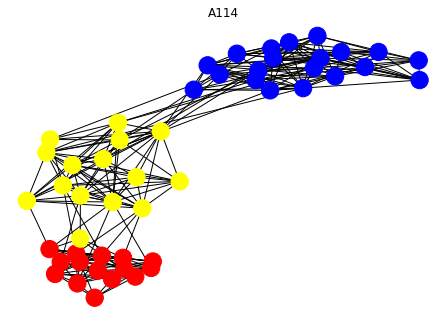

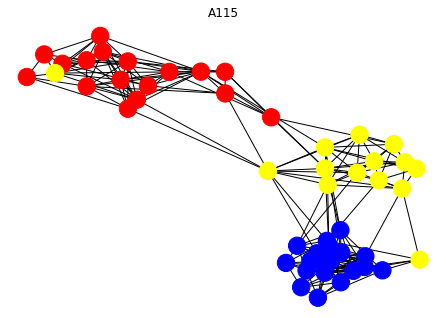

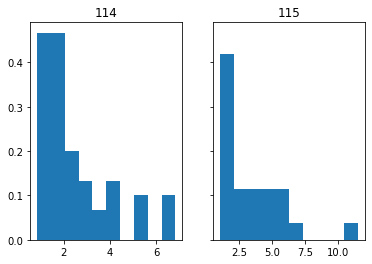

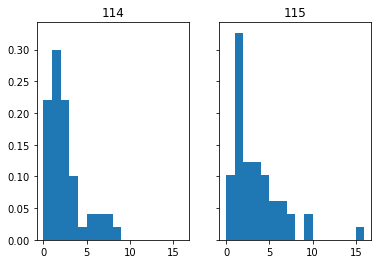

In [138]:
plt.figure()
nx.draw_spring(nx.nx.from_numpy_matrix(A), node_color=colors114)
plt.title('A0')

plt.figure()
nx.draw_spring(nx.nx.from_numpy_matrix(A), node_color=colors115)
plt.title('A')

degrees0  = np.diag(L0)
degrees  = np.diag(L)
figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(degrees0, density=True)
axs[0].set_title('Degree distribution of L0')
axs[1].hist(degrees, density=True)
axs[1].set_title('Degree distribution of L')

print(np.mean(degrees0), np.mean(degrees))
print(np.median(degrees0), np.median(degrees))

n_bins = np.arange(0,np.amax(lambdas)+1,1)

figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True, bins=n_bins)
axs[0].set_title('Spectral distribution of L0')
axs[1].hist(lambdas, density=True, bins=n_bins)
axs[1].set_title('Spectral distribution of L')

cs, _ = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

### Experiment parameters

In [5]:
n_covs = 10  # 50
MM = [50, 100, 200, 300]  # np.arange(50, 401, 25)
iters = 200

deltas = [.86, 9, .05, 1.7]
models = [
    # Baselines
    # {'name': 'GLasso', 'alpha': 0.1, 'fmt': '^--'},
    {'name': 'MGL-Tr=1', 'cs': 1, 'gs': GS[0], 'bounds': [], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': .5, 'gamma': 0, 'deltas': 1e-4}},
    {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': 0, 'beta': 2, 
     'c1': .01, 'c2': 20, 'conn_comp': 1}},
    {'name': 'Unc', 'cs': [], 'gs': [], 'bounds': [], 'fmt': 'v-',
     'regs': {'alpha': .01, 'beta': 5, 'gamma': 0, 'deltas': []}},

    # Our algorithms
    {'name': 'MGL-Tr', 'cs': cs[0], 'gs': GS[0], 'bounds': [], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': .4, 'gamma': 0, 'deltas': deltas[0]}},
    {'name': 'MGL-Sq', 'cs': cs[1], 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
     'regs': {'alpha': 0, 'beta': .5, 'gamma': 10000, 'deltas': deltas[1]}},
    {'name': 'MGL-Heat', 'cs': cs[2], 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
     'regs': {'alpha': 0, 'beta': 1.8, 'gamma': 1000, 'deltas': deltas[2]}},
    {'name': 'MGL-Poly', 'cs': cs[3], 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': .4, 'gamma': 10000, 'deltas': deltas[3]}},
]

### Run and plot experiment

In [6]:
# Estimate graph
N = L.shape[0]
total_t = time.time()
Ls_hat = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, L, iters) for i in range(n_covs))
for i, resp in enumerate(resps):
    Ls_hat[:,:,:,:,i], lamds_hat[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 31.09143037398656  mins -----


In [13]:
err_L, err_lamb = est_errs2(L, lambdas, Ls_hat, lamds_hat, sq_err=True)
mean_errL = np.mean(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM, models, mean_errL, 'Mean Err2 L')
plot_err(MM, models, mean_err_lam, 'Mean Err2 lambdas')

In [15]:
# Plot error 1
err_L, err_lamb = est_errs1(L, lambdas, Ls_hat, lamds_hat)
mean_errL = np.mean(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM, models, mean_errL, 'Mean Err1 L')


In [10]:
# Save data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': \
#                model['regs'] if 'regs' in model.keys() else {}} 
#                for model in models]

# data = {
#     'L': L,
#     'lambdas': lambdas,
#     'Ls_hat': Ls_hat,
#     'lamds_hat': lamds_hat,
#     'MM': MM,
#     'models': models_aux
# }
# file = 'students_{}covs_{}iters_graphs{}-{}'.format(n_covs, iters,
#     graphs_idx[0], graphs_idx[1])
# np.save('results/student_network/' + file, data)

### Looking for other ground true graphs

Text(0.5, 1.0, 'A113')

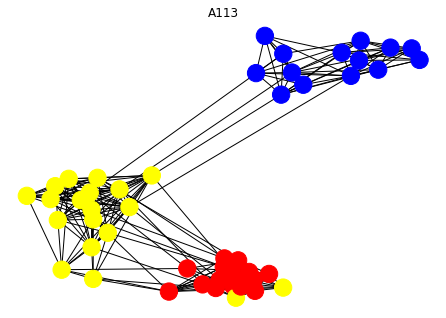

In [130]:
regs113 = {'alpha': .05, 'beta': 5}
L113, _ = snti.MGL(C113, [], [], [], regs113, max_iters=200, verbose=False)
A113 = np.diag(np.diag(L113)) - L113
lambdas113, _ = np.linalg.eigh(L113)

plt.figure()
nx.draw_spring(nx.nx.from_numpy_matrix(A113), node_color=colors113)
plt.title('A113')

Text(0.5, 1.0, 'A114')

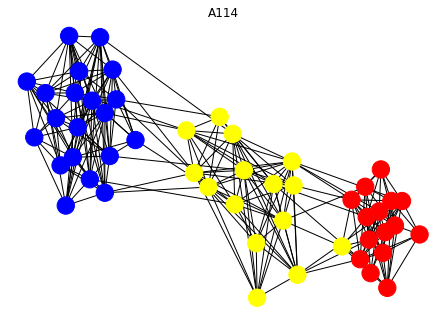

In [131]:
regs114 = {'alpha': .01, 'beta': 7.5}
# regs114 = {'alpha': .05, 'beta': 8}
L114, _ = snti.MGL(C114, [], [], [], regs114, max_iters=200, verbose=False)
lambdas114, _ = np.linalg.eigh(L114)
A114 = np.diag(np.diag(L114)) - L114

plt.figure()
nx.draw_spring(nx.nx.from_numpy_matrix(A114), node_color=colors114)
plt.title('A114')

Text(0.5, 1.0, 'A115')

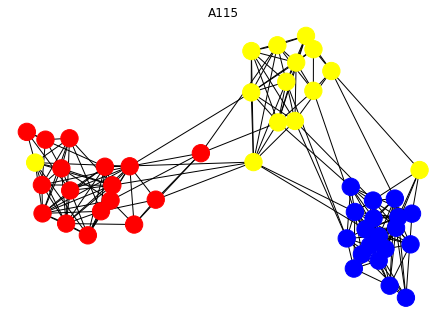

In [135]:
regs115 = {'alpha': .1, 'beta': 5}
# regs115 = {'alpha': .01, 'beta': 7.5}
L115, _ = snti.MGL(C115, [], [], [], regs115, max_iters=200, verbose=False)
lambdas115, _ = np.linalg.eigh(L115)
A115 = np.diag(np.diag(L115)) - L115

plt.figure()
nx.draw_spring(nx.nx.from_numpy_matrix(A115), node_color=colors115)
plt.title('A115')

2.5189336628444856 2.9705931205395903
113 vs 114
	c-0: c: 2.971	c0: 2.519	err: 0.451659	err norm: 0.179306
	c-1: c: 15.748	c0: 10.580	err: 5.168002	err norm: 0.488476
	c-2: c: 0.188	c0: 0.202	err: -0.013985	err norm: -0.069348
	c-3: c: 1.709	c0: 0.756	err: 0.953256	err norm: 1.261315


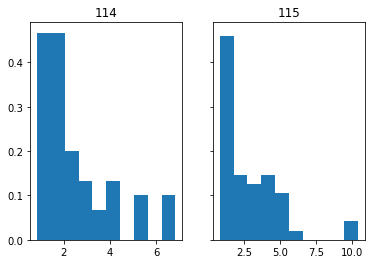

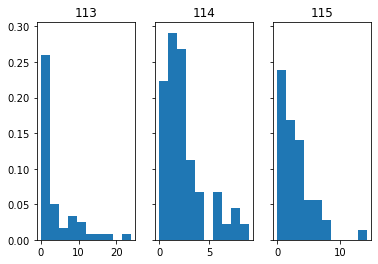

In [136]:
# Compute CS
lambdas113, _ = np.linalg.eigh(L113)
lambdas114, _ = np.linalg.eigh(L114)
lambdas115, _ = np.linalg.eigh(L115)

degrees114  = np.diag(L114)
degrees115  = np.diag(L115)
figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(degrees114, density=True)
axs[0].set_title('114')
axs[1].hist(degrees115, density=True)
axs[1].set_title('115')

print(np.mean(degrees114), np.mean(degrees115))

figs, axs = plt.subplots(1, 3, sharey=True)
axs[0].hist(lambdas113, density=True)
axs[0].set_title('113' )
axs[1].hist(lambdas114, density=True)
axs[1].set_title('114')
axs[2].hist(lambdas115, density=True)
axs[2].set_title('115')

print('113 vs 114')
# cs, _ = utils.compute_cs(GS, lambdas113, lambdas114, verbose=True)
# print('114 vs 115')
cs, _ = utils.compute_cs(GS, lambdas114, lambdas115, verbose=True)
# print('113 vs 115')
# cs, _ = utils.compute_cs(GS, lambdas113, lambdas115, verbose=True)